# Projeto Spark

A ser realizado individualmente.

Entrega: 17 de junho de 2022


In [1]:
import pyspark
import re 
from math import log10

In [2]:
conf = pyspark.SparkConf()
conf.setAppName('Minha aplicação')
conf.setMaster('local[*]')


sc = pyspark.SparkContext(conf=conf)

In [3]:
sc

<SparkContext master=local[*] appName=Minha aplicação>

## Introdução

Neste projeto vamos construir um classificador Naive-Bayes para determinar o sentimento de um comentário. Vamos começar lendo o arquivo de reviews e gravando o resultado em formato pickle, mais amigável.

In [4]:
def parse_line(line):
    parts = line[1:-1].split('","')
    sentiment = int(parts[0])
    title = parts[1].replace('""', '"')
    body = parts[2].replace('""', '"')
    return (sentiment, title, body)


rdd = sc.textFile('train.csv').map(parse_line)

In [5]:
rdd.count()

3600000

In [6]:
rdd.take(1)

[(2,
  'Stuning even for the non-gamer',
  'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')]

Agora vamos gravar no formato pickle, para facilitar os trabalhos futuros. Após gravar o arquivo, não mais rode as células desta primeira etapa!

In [ ]:
#rdd.saveAsPickleFile('reviews.pickle')

## Um classificador Naive-Bayes

Vamos ler o arquivo pickle gravado anteriormente:

In [7]:
rdd = sc.pickleFile('reviews.pickle')

# Pegando algumas amostras, para rodar mais rápido
rdd = rdd.sample("withReplacement", 0.001, 3)

In [8]:
test, train = rdd.randomSplit(weights=[0.3, 0.7], seed=1)

In [9]:
test.count()

1017

Agora, complete as tarefas em sequencia para construir o classificador Naive-Bayes:

### Fase 1

#### Tarefa

Construa uma função que recebe um RDD no formato do RDD original e retorna um RDD no qual cada item é um par (palavra, contagem).

In [10]:
def cleanup(string):
    punctuation = '[_ ! - . : ? ; @ , # / " * ( )]' # Sinais que serão substituidos por espaços
    pattern = re.compile(punctuation)
    string_sem_pontuacao = re.sub(pattern, ' ', string) # Retirando sinais
    return string_sem_pontuacao


def split_word(item):
    title = cleanup(item[1])
    body = cleanup(item[2])
    return title.split()+body.split()


def count_each_word(rdd):
    return rdd.flatMap(split_word) \
              .map(lambda x: (x, 1)) \
              .reduceByKey(lambda x, y: x + y)

#### Tarefa

Construa uma função que recebe o RDD (palavra, contagem) construido anteriormente e retorna um RDD no qual cada item é um par (palavra, $\log_{10}\left(c \, / \, T\right)$), onde $c$ é a contagem daquela palavra e $T$ é a soma das contagens de palavra.

In [11]:
def compute_prob(rdd):
    T = count_each_word(rdd).map(lambda x: x[1])\
                            .reduce(lambda x, y: x + y)

    return count_each_word(rdd).map(lambda x: (x[0], log10(x[1]/T))), T

#### Tarefa

Separe o RDD original em dois RDDs: o dos reviews positivos e o dos negativos. Em seguida, use as funções anteriores para construir RDDs que contem os pares (palavra, $\log_{10}\left(c \, / \, T\right)$)

In [12]:
def split_reviews(rdd):
    positive = rdd.filter(lambda x: x[0] == 2)
    negative = rdd.filter(lambda x: x[0] == 1)
    return positive, negative

positive_reviews, negative_reviews = split_reviews(train)
prob_positive, total_positive = compute_prob(positive_reviews)
prob_negative, total_negative = compute_prob(negative_reviews)

total_words = total_positive + total_negative
total_words

201705

In [13]:
prob_positive.take(1)

[('book', -2.145260148585279)]

### Tarefa

Use o `.fullOuterJoin()` dos RDDs para construir um RDD unificado, no qual cada item é da forma (palavra, log_prob_positivo, log_prob_negativo). "Baixe" esse resultado final usando `.collect()`.

In [14]:
def remove_none(x):
    word, probs = x
    probs_positive, probs_negative = probs
    
    if probs_positive == None:
        probs_positive = log10(1/total_words)
        
    elif probs_negative == None:
        probs_negative = log10(1/total_words)
        
    return (word, (probs_positive, probs_negative))
        
join_rdd = prob_positive.fullOuterJoin(prob_negative)
join_rdd = join_rdd.map(remove_none)

In [15]:
join_rdd.take(20)

[('Christian', (-4.219588891838492, -4.231401620404421)),
 ('family', (-3.4295384181551403, -3.7542803656847585)),
 ('start', (-3.4925901639022294, -3.6873335760541455)),
 ('catholic', (-4.997740142222136, -5.304716663931631)),
 ('out', (-2.5647708513477294, -2.514008533241616)),
 ('altar', (-4.997740142222136, -5.304716663931631)),
 ('gift', (-3.5998001335500978, -3.647825034770472)),
 ('narrative', (-4.298770137886117, -4.708522875124084)),
 ('im', (-4.219588891838492, -4.532431616068402)),
 ('Jackass', (-4.696710146558154, -5.304716663931631)),
 ('destruction', (-4.520618887502473, -4.708522875124084)),
 ('fusion', (-4.696710146558154, -5.304716663931631)),
 ('teaching', (-4.0434976327828105, -4.708522875124084)),
 ('common', (-4.395680150894173, -4.164454830773808)),
 ('ALWAYS', (-4.696710146558154, -4.708522875124084)),
 ('Bells', (-4.696710146558154, -5.009552870788065)),
 ('Nature', (-4.696710146558154, -5.009552870788065)),
 ('engagingly', (-4.997740142222136, -5.30471666393163

In [16]:
join_rdd_dict = dict(join_rdd.collect())

#### Tarefa

Para uma dada string, determine se ela é um review positivo ou negativo usando os RDDs acima. Lembre-se de como funciona o classificador Naive-Bayes: http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf, consulte tambem suas notas de aula de Ciência dos Dados!

In [17]:
def naive_bayes_classifier(string):
    string = string.lower()
    prob_negative = 0
    prob_positive = 0
    string_splited = string.split(" ")
    
    for word in string_splited:
        if word in join_rdd_dict.keys():
            prob_positive += join_rdd_dict[word][0]
            prob_negative += join_rdd_dict[word][1]
        else:
            prob_positive += log10(1/total_words)
            prob_negative += log10(1/total_words)
            
    classification = None
    
    if prob_negative > prob_positive:
        classification = 1
    else:
        classification = 2
        
    return classification

In [18]:
naive_bayes_classifier("I love this")

2

In [19]:
naive_bayes_classifier("I hate this")

1

### Fase 2

Agora que temos um classificador Naive-Bayes, vamos explorá-lo um pouco:

### Tarefa

Quais são as 100 palavras que mais indicam negatividade, ou seja, onde a diferença entre a probabilidade da palavra no conjunto dos comentários negativos e positivos é máxima? E quais as 100 palavras de maior positividade? Mostre os resultados na forma de *word clouds*.

In [20]:
#! pip install wordcloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [21]:
negatives = join_rdd.takeOrdered(100, key=lambda x: (x[1][0]-x[1][1]))
postives = join_rdd.takeOrdered(100, key=lambda x: -(x[1][0]-x[1][1])) 

In [22]:
postives_words = [i[0] for i in postives]
negatives_words = [i[0] for i in negatives]

In [23]:
def word_cloud_creator(words_list):
    comment_words = ''
    stopwords = set(STOPWORDS)

    for word in words_list:       
        # typecaste each val to string 
        word = str(word) 

        # split the value 
        tokens = word.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "
        
    wordcloud = WordCloud(width = 800, 
                      height = 800, 
                      background_color ='white', 
                      stopwords = stopwords, 
                      min_font_size = 10).generate(comment_words) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

### POSITIVOS

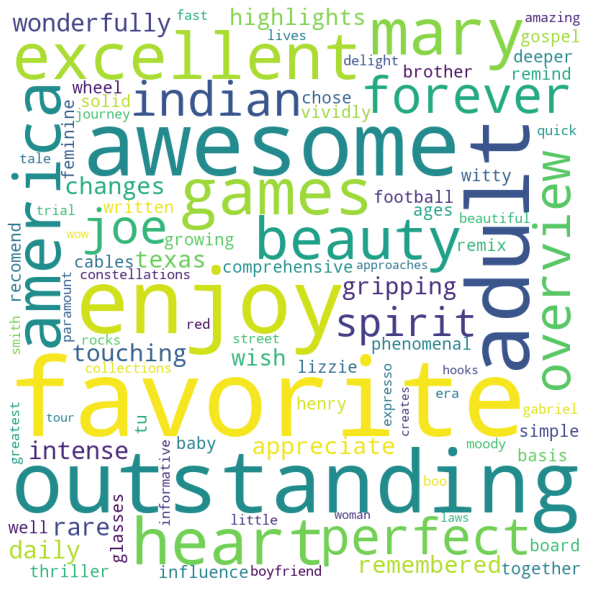

In [24]:
word_cloud_creator(postives_words)

### NEGATIVOS

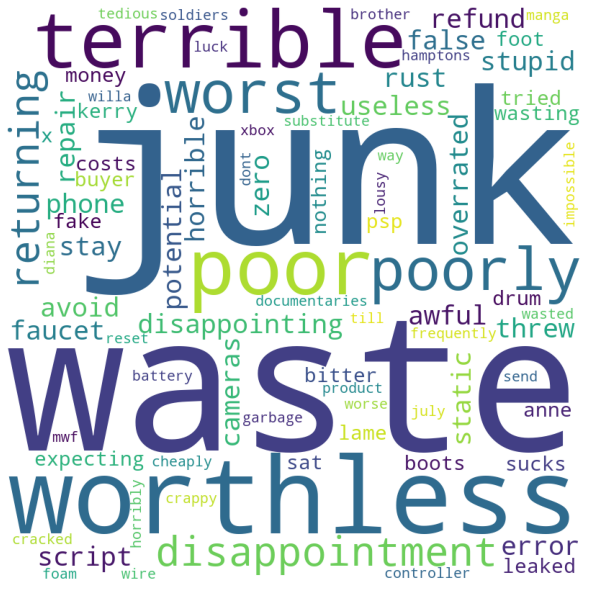

In [25]:
word_cloud_creator(negatives_words)

### Tarefa desafio!

Qual o desempenho do classificador (acurácia)? Para medir sua acurácia:

- Separe os reviews em dois conjuntos: treinamente e teste
- Repita o "treinamento" do classificador com o conjunto de treinamento
- Para cada review do conjunto de teste, determine se é positiva ou negativa de acordo com o classificador
- Determine a acurácia

Esta não é uma tarefa trivial. Não basta fazer um `for` para determinar a classe de cada review de teste: isso demoraria uma eternidade. Você tem que usar variáveis "broadcast" do Spark para enviar uma cópia da tabela de frequencias para cada *core* do executor.

In [29]:
def get_review_words(item):
    classification = item[0]
    title = cleanup(item[1])
    body = cleanup(item[2])
    return (classification, title+body)

def classificate_review(item):
    real_classification = item[0]
    trained_classification = naive_bayes_classifier(item[1])
    return (real_classification, trained_classification)

def get_accuracy(results):
    total_correct = 0
    for result in results:
        real_classification, trained_classification = result
        if real_classification == trained_classification:
            total_correct += 1
            
    return total_correct/len(results)

results = test.map(get_review_words).map(classificate_review).collect()
get_accuracy(results)

0.7630285152409046

### Tarefa desafio!

Implemente Laplace smoothing

In [ ]:
# Não Feito!

## Rubrica de avaliação

- I: groselha, falha crítica, ou não entregou nada
- D: Fez uma tentativa honesta de fazer todos os itens da fase 1, mas tem erros
- C: Fase 1 completa
- B: Fase 2, faltando apenas um desafio
- A: Fase 2 completa

In [ ]:
# Rúbrica B hein professor!